In [7]:
# --- Import libraries
import json
import re
import pandas as pd
from urllib.request import urlopen
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report

In [10]:
# --- Define company list
response = urlopen('https://financialmodelingprep.com/api/v3/stock/list?apikey=f33b3631d5140a4f1c87e7f2eafd8fdd')
data=response.read().decode('utf-8')
raw_list=json.loads(data)
raw_list

[{'symbol': 'SPY',
  'name': 'SPDR S&P 500 ETF Trust',
  'price': 439.01,
  'exchange': 'New York Stock Exchange Arca'},
 {'symbol': 'CMCSA',
  'name': 'Comcast Corporation',
  'price': 58.56,
  'exchange': 'Nasdaq Global Select'},
 {'symbol': 'KMI',
  'name': 'Kinder Morgan, Inc.',
  'price': 17.75,
  'exchange': 'New York Stock Exchange'},
 {'symbol': 'INTC',
  'name': 'Intel Corporation',
  'price': 53.18,
  'exchange': 'Nasdaq Global Select'},
 {'symbol': 'MU',
  'name': 'Micron Technology, Inc.',
  'price': 74.22,
  'exchange': 'Nasdaq Global Select'},
 {'symbol': 'GDX',
  'name': 'VanEck Vectors Gold Miners ETF',
  'price': 33.68,
  'exchange': 'New York Stock Exchange Arca'},
 {'symbol': 'GE',
  'name': 'General Electric Company',
  'price': 13.08,
  'exchange': 'New York Stock Exchange'},
 {'symbol': 'BAC',
  'name': 'Bank of America Corporation',
  'price': 37.98,
  'exchange': 'New York Stock Exchange'},
 {'symbol': 'EEM',
  'name': 'iShares MSCI Emerging Markets ETF',
  'pri

In [11]:
clean_list = [i['symbol'] for i in raw_list if i['exchange']=='Nasdaq Global Select']

In [12]:
len(clean_list)

2323

In [13]:
# --- Get all earnings call report
def get_jsonparsed_data(company,year):
    response = urlopen(f'https://financialmodelingprep.com/api/v4/batch_earning_call_transcript/{company}?year={year}&apikey=f33b3631d5140a4f1c87e7f2eafd8fdd')
    data = response.read().decode("utf-8")
    return json.loads(data)
AAPL = get_jsonparsed_data('AAPL',2020)

In [ ]:
AAPL

In [15]:
n = 0
earnings_call = []
for i in clean_list:
    try:
        earnings_call.append(get_jsonparsed_data(i,2019))
        earnings_call.append(get_jsonparsed_data(i,2020))
        n += 1
        print(f'Successfully download report for {i}. It is the no. {n} report.')
    except:
        print(f'Cannot return report for {i}.')
        pass
with open('earnings_call.txt', 'w') as outfile:
    json.dump(earnings_call, outfile)
print(f'Successfully download {n} reports.')

Successfully download report for CMCSA. It is the no. 1 report.
Successfully download report for INTC. It is the no. 2 report.
Successfully download report for MU. It is the no. 3 report.
Successfully download report for AAPL. It is the no. 4 report.
Successfully download report for MSFT. It is the no. 5 report.
Successfully download report for SIRI. It is the no. 6 report.
Successfully download report for CZR. It is the no. 7 report.
Successfully download report for FB. It is the no. 8 report.
Successfully download report for GSM. It is the no. 9 report.
Successfully download report for JD. It is the no. 10 report.
Successfully download report for AVGO. It is the no. 11 report.
Successfully download report for AMAT. It is the no. 12 report.


In [ ]:
f = open('earnings_call.txt')
data = json.load(f)
data[0]

In [ ]:
list_full = []
for i in data:
    for j in i:
        if j['quarter']==4:
            list_full.append(j)
        else:
            pass
list_full[0]

In [10]:
full = pd.DataFrame(list_full)
full

,symbol,quarter,year,date,content
0,CMCSA,4,2019,2020-01-23 12:04:23,"Operator: Good morning, ladies and gentlemen, ..."
1,CMCSA,4,2020,2021-01-28 14:31:06,"Operator: Good morning, ladies and gentlemen, ..."
2,INTC,4,2019,2020-01-24 17:00:00,"Operator: Ladies and gentlemen, thank you for ..."
3,INTC,4,2020,2021-01-22 00:58:06,"Operator: Ladies and gentlemen, thank you for ..."
4,MU,4,2019,2019-09-27 17:00:00,"Operator: Good afternoon. My name is Sherry, a..."
...,...,...,...,...,...
2237,CNXC,4,2020,2021-01-12 12:35:03,"Operator: Ladies and gentlemen, thank you for ..."
2238,PLBY,4,2020,2021-03-23 18:40:09,Operator: Thank you for standing by. And welco...
2239,CLOV,4,2020,2021-03-01 22:17:05,"Operator: Ladies and gentlemen, thank you for ..."
2240,AXON,4,2020,2021-02-25 23:08:03,"Andrea James: Hello, everyone. Welcome to Axon..."


In [11]:
def word_preprocess(n):
    # --- Remove separaters
    n = re.sub(r'\n', '', n)
    n = re.sub(r'--','', n)
    # --- Remove stopword
    stop_words = set(stopwords.words('english')+list(punctuation))
    words_token = [w for w in word_tokenize(n) if not w.lower() in stop_words]
    filtered_sentence = [i for i in words_token if i not in stop_words]
    # --- Lemmatize
    lemmatizer = WordNetLemmatizer()
    clean_list = ",".join([lemmatizer.lemmatize(i) for i in filtered_sentence])
    return clean_list

In [ ]:
full['content_clean'] = full['content'].apply(word_preprocess)

In [ ]:
full['code']=full['symbol']+full['year'].astype(str)
full=full[['code','content','content_clean']]
full.head()

,code,content,content_clean
0,CMCSA2019,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C..."
1,CMCSA2020,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C..."
2,INTC2019,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco..."
3,INTC2020,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco..."
4,MU2019,"Operator: Good afternoon. My name is Sherry, a...","Operator,Good,afternoon,name,Sherry,conference..."


In [146]:
full.to_csv('full.csv')

In [3]:
full = pd.read_csv('full.csv')

In [ ]:
# --- Get financial ratios: growth figures
def get_jsonparsed_data_ratio(company):
    response = urlopen(f'https://financialmodelingprep.com/api/v3/financial-growth/{company}?limit=20&apikey=f33b3631d5140a4f1c87e7f2eafd8fdd')
    data = response.read().decode("utf-8")
    return json.loads(data)
AAPL = get_jsonparsed_data_ratio('AAPL')
AAPL

In [9]:
n = 0
ratio = []
for i in clean_list:
    try:
        ratio.append(get_jsonparsed_data_ratio(i))
        n += 1
        print(f'Successfully download ratio for {i}. It is the no. {n} report.')
    except:
        print(f'Cannot return ratio for {i}.')
        pass
with open('ratio.txt', 'w') as outfile:
    json.dump(ratio, outfile)
print(f'Successfully download {n} reports.')

NameError: name 'clean_list' is not defined

In [6]:
f = open('ratio.txt')
ratio = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'ratio.txt'

In [4]:
ratio_temp = []
for i in ratio:
    for j in i:
        if j['date'].startswith('2020') or j['date'].startswith('2019'):
            ratio_temp.append(j)
        else:
            pass
ratio_full = pd.DataFrame(ratio_temp)
ratio_full = ratio_full[['symbol','date','netIncomeGrowth','dividendsperShareGrowth']]

In [5]:
ratio_full.head()

,symbol,date,netIncomeGrowth,dividendsperShareGrowth
0,CMCSA,2020-12-31,-0.193230,0.115534
1,CMCSA,2019-12-31,0.113034,0.121511
2,INTC,2020-12-26,-0.007079,0.077348
3,INTC,2019-12-28,-0.000237,0.055300
4,MU,2020-09-03,-0.574370,0.000000


In [6]:
# --- Positive grwoth rate as 1
ratio_full['Income_growth'] = ratio_full['netIncomeGrowth'].apply(lambda x: int(x>0))
ratio_full['Dividend_growth'] = ratio_full['dividendsperShareGrowth'].apply(lambda x: int(x>0))
ratio_full['year']=ratio_full['date'].apply(lambda x: x[0:4])
ratio_full['code']=ratio_full['symbol']+ratio_full['year'].astype(str)
ratio_full = ratio_full[['code','netIncomeGrowth','Income_growth','dividendsperShareGrowth','Dividend_growth']]
ratio_full.head()

,code,netIncomeGrowth,Income_growth,dividendsperShareGrowth,Dividend_growth
0,CMCSA2020,-0.193230,0,0.115534,1
1,CMCSA2019,0.113034,1,0.121511,1
2,INTC2020,-0.007079,0,0.077348,1
3,INTC2019,-0.000237,0,0.055300,1
4,MU2020,-0.574370,0,0.000000,0


In [7]:
result = pd.merge(full, ratio_full, how="outer", on=['code'])
result.head()

,Unnamed: 0,code,content,content_clean,netIncomeGrowth,Income_growth,dividendsperShareGrowth,Dividend_growth
0,0.0,CMCSA2019,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",0.113034,1.0,0.121511,1.0
1,1.0,CMCSA2020,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",-0.193230,0.0,0.115534,1.0
2,2.0,INTC2019,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",-0.000237,0.0,0.055300,1.0
3,3.0,INTC2020,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",-0.007079,0.0,0.077348,1.0
4,4.0,MU2019,"Operator: Good afternoon. My name is Sherry, a...","Operator,Good,afternoon,name,Sherry,conference...",-0.553378,0.0,0.000000,0.0


In [8]:
result.isna().sum()

Unnamed: 0                 1397
code                          0
content                    1397
content_clean              1397
netIncomeGrowth              33
Income_growth                33
dividendsperShareGrowth      33
Dividend_growth              33
dtype: int64

In [9]:
result.dropna(inplace=True)

In [10]:
result.isna().sum()

Unnamed: 0                 0
code                       0
content                    0
content_clean              0
netIncomeGrowth            0
Income_growth              0
dividendsperShareGrowth    0
Dividend_growth            0
dtype: int64

In [14]:
# --- Logistic regression model, income

X = result['content']
y = result['Income_growth']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [16]:
cv = CountVectorizer()
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

In [24]:
lgr = LogisticRegression(C=0.05, n_jobs=-1)
grid = GridSearchCV(lgr, param_grid={'max_iter': [100, 200, 300, 400, 500]})
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.52      0.53       227
         1.0       0.52      0.55      0.53       217

    accuracy                           0.53       444
   macro avg       0.53      0.53      0.53       444
weighted avg       0.53      0.53      0.53       444



In [161]:
X = result['content_clean']
y = result['Income_growth']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.54      0.55       227
         1.0       0.54      0.55      0.54       217

    accuracy                           0.55       444
   macro avg       0.55      0.55      0.55       444
weighted avg       0.55      0.55      0.55       444



In [228]:
# Dividend

X = result['content_clean']
y = result['Dividend_growth']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       318
         1.0       0.61      0.58      0.60       126

    accuracy                           0.78       444
   macro avg       0.73      0.72      0.72       444
weighted avg       0.77      0.78      0.78       444



In [190]:
sid = SentimentIntensityAnalyzer()
def senti(n):
    return sid.polarity_scores(n)
senti(full['content'][500])

{'neg': 0.024, 'neu': 0.864, 'pos': 0.113, 'compound': 1.0}

In [177]:
result['senti_score'] = result['content'].apply(senti)

,code,content,content_clean,growth,senti_score
0,CMCSA2019,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",1.0,1.0
1,CMCSA2020,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",0.0,1.0
2,INTC2019,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",0.0,1.0
3,INTC2020,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",0.0,1.0
4,MU2019,"Operator: Good afternoon. My name is Sherry, a...","Operator,Good,afternoon,name,Sherry,conference...",0.0,1.0


In [191]:
result.groupby('senti_score').count()

,code,content,content_clean,growth,sentiment
senti_score,,,,,
0.9904,1,1,1,1,1
0.9913,1,1,1,1,1
0.9942,1,1,1,1,1
0.9960,1,1,1,1,1
0.9977,1,1,1,1,1
0.9978,1,1,1,1,1
0.9979,1,1,1,1,1
0.9983,2,2,2,2,2
0.9984,1,1,1,1,1


In [230]:
def get_polarity(n):
    return TextBlob(n).sentiment.polarity
result['polarity_score'] = result['content'].apply(get_polarity)
result.head()

,code,content,content_clean,senti_score,netIncomeGrowth,Income_growth,dividendsperShareGrowth,Dividend_growth,polarity_score
0,CMCSA2019,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",1.0,0.113034,1.0,0.121511,1.0,0.232600
1,CMCSA2020,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",1.0,-0.193230,0.0,0.115534,1.0,0.217182
2,INTC2019,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",1.0,-0.000237,0.0,0.055300,1.0,0.152803
3,INTC2020,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",1.0,-0.007079,0.0,0.077348,1.0,0.188381
4,MU2019,"Operator: Good afternoon. My name is Sherry, a...","Operator,Good,afternoon,name,Sherry,conference...",1.0,-0.553378,0.0,0.000000,0.0,0.109520


(-10.0, 10.0)

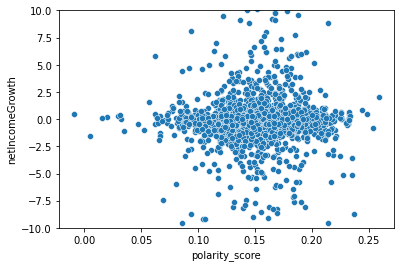

In [214]:
sns.scatterplot(data=result, x='polarity_score', y='netIncomeGrowth')
plt.ylim(-10,10)

(-3.0, 3.0)

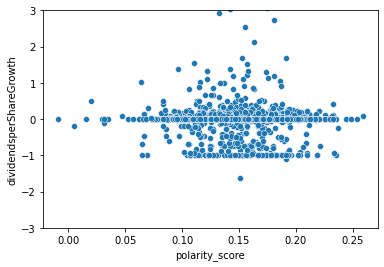

In [232]:
sns.scatterplot(data=result, x='polarity_score', y='dividendsperShareGrowth')
plt.ylim(-3,3)

In [6]:
# Doing all available ratios
ratio_temp = []
for i in ratio:
    for j in i:
        if j['date'].startswith('2020') or j['date'].startswith('2019'):
            ratio_temp.append(j)
        else:
            pass
ratio_full_temp = pd.DataFrame(ratio_temp)
ratio_full_temp['year']=ratio_full_temp['date'].apply(lambda x: x[0:4])
ratio_full_temp['code']=ratio_full_temp['symbol']+ratio_full_temp['year'].astype(str)
ratio_full_temp = ratio_full_temp.iloc[:,3:]
def growth(n):
    return (n>0).astype(int)  
ratio_full_temp.iloc[:,0:-2] = ratio_full_temp.iloc[:,0:-2].apply(growth)
result_temp = pd.merge(full, ratio_full_temp, how="outer", on=['code'])
result_temp.dropna(inplace=True)
result_temp

,Unnamed: 0,code,content,content_clean,revenueGrowth,grossProfitGrowth,ebitgrowth,operatingIncomeGrowth,netIncomeGrowth,epsgrowth,...,fiveYDividendperShareGrowthPerShare,threeYDividendperShareGrowthPerShare,receivablesGrowth,inventoryGrowth,assetGrowth,bookValueperShareGrowth,debtGrowth,rdexpenseGrowth,sgaexpensesGrowth,year
0,0.0,CMCSA2019,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2019
1,1.0,CMCSA2020,"Operator: Good morning, ladies and gentlemen, ...","Operator,Good,morning,lady,gentleman,welcome,C...",0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2020
2,2.0,INTC2019,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2019
3,3.0,INTC2020,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2020
4,4.0,MU2019,"Operator: Good afternoon. My name is Sherry, a...","Operator,Good,afternoon,name,Sherry,conference...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,2237.0,CNXC2020,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2020
2248,2238.0,PLBY2020,Operator: Thank you for standing by. And welco...,"Operator,Thank,standing,welcome,Fourth,Quarter...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2020
2249,2239.0,CLOV2020,"Operator: Ladies and gentlemen, thank you for ...","Operator,Ladies,gentleman,thank,standing,welco...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2020
2250,2240.0,AXON2020,"Andrea James: Hello, everyone. Welcome to Axon...","Andrea,James,Hello,everyone,Welcome,Axon,'s,Fo...",1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2020


In [10]:
rate_list = list(ratio[0][0].keys())[3:]
rate_list

['revenueGrowth',
 'grossProfitGrowth',
 'ebitgrowth',
 'operatingIncomeGrowth',
 'netIncomeGrowth',
 'epsgrowth',
 'epsdilutedGrowth',
 'weightedAverageSharesGrowth',
 'weightedAverageSharesDilutedGrowth',
 'dividendsperShareGrowth',
 'operatingCashFlowGrowth',
 'freeCashFlowGrowth',
 'tenYRevenueGrowthPerShare',
 'fiveYRevenueGrowthPerShare',
 'threeYRevenueGrowthPerShare',
 'tenYOperatingCFGrowthPerShare',
 'fiveYOperatingCFGrowthPerShare',
 'threeYOperatingCFGrowthPerShare',
 'tenYNetIncomeGrowthPerShare',
 'fiveYNetIncomeGrowthPerShare',
 'threeYNetIncomeGrowthPerShare',
 'tenYShareholdersEquityGrowthPerShare',
 'fiveYShareholdersEquityGrowthPerShare',
 'threeYShareholdersEquityGrowthPerShare',
 'tenYDividendperShareGrowthPerShare',
 'fiveYDividendperShareGrowthPerShare',
 'threeYDividendperShareGrowthPerShare',
 'receivablesGrowth',
 'inventoryGrowth',
 'assetGrowth',
 'bookValueperShareGrowth',
 'debtGrowth',
 'rdexpenseGrowth',
 'sgaexpensesGrowth']

In [9]:
# --- Find accuracy score for all growth rate
scores = {}
lgr = LogisticRegression(C=0.05, n_jobs=-1)

def logistic(n):
    X = result_temp['content_clean']
    y = result_temp[n]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    cv = CountVectorizer()
    X_train = cv.fit_transform(X_train)
    X_test = cv.transform(X_test)
    grid = GridSearchCV(lgr, param_grid={'max_iter': [100, 200, 300, 400, 500]})
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    s = accuracy_score(y_test, y_pred)
    scores[n] = s

    pickle.dump(cv, open('model/cv.pkl', 'wb'))
    print(f'Accuracy score for {n} is {s}.')
    
for i in rate_list:
    logistic(i)
df = pd.DataFrame.from_dict(scores, orient = 'index', columns = ['score'])
df.sort_values(by='score', ascending=False)

Accuracy score for tenYDividendperShareGrowthPerShare is 0.8355855855855856.
Accuracy score for fiveYDividendperShareGrowthPerShare is 0.8130630630630631.
Accuracy score for threeYDividendperShareGrowthPerShare is 0.8040540540540541.
Accuracy score for tenYRevenueGrowthPerShare is 0.7792792792792793.
Accuracy score for fiveYRevenueGrowthPerShare is 0.7972972972972973.
Accuracy score for threeYRevenueGrowthPerShare is 0.7184684684684685.


,score
tenYDividendperShareGrowthPerShare,0.835586
fiveYDividendperShareGrowthPerShare,0.813063
threeYDividendperShareGrowthPerShare,0.804054
fiveYRevenueGrowthPerShare,0.797297
tenYRevenueGrowthPerShare,0.779279
threeYRevenueGrowthPerShare,0.718468


In [ ]:
df = pd.DataFrame.from_dict(scores, orient = 'index', columns = ['score'])
df.sort_values(by='score', ascending=False)